In [327]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric import datasets
from torch_geometric.data import Data
from functools import cache
from tqdm import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score

In [328]:
@cache
def edge_index_to_adj(edge_index: torch.tensor, num_nodes: int) -> torch.tensor:
	adj = torch.zeros(num_nodes, num_nodes)
	adj[edge_index[0], edge_index[1]] = 1
	return adj

@cache
def adj_to_edge_index(adj: torch.tensor) -> torch.tensor:
	return adj.nonzero().t().contiguous()

@cache
def get_masked_adj(adj: torch.tensor, mask: torch.tensor) -> torch.tensor:
	return adj[mask][:, mask]

# Graph Autoencoder (GAE)
The GAE model is a simple graph autoencoder that learns a low-dimensional node representation.

In [329]:
dataset = datasets.Planetoid(root='../data/', name='Cora', split='full')[0]
adj = edge_index_to_adj(dataset.edge_index, dataset.num_nodes)
train_data, val_data, test_data = Data(), Data(), Data()
train_data.x, train_data.adj, train_data.y = dataset.x[dataset.train_mask], get_masked_adj(adj, dataset.train_mask), dataset.y[dataset.train_mask]
val_data.x, val_data.adj, val_data.y = dataset.x[dataset.val_mask], get_masked_adj(adj, dataset.val_mask), dataset.y[dataset.val_mask]
test_data.x, test_data.adj, test_data.y = dataset.x[dataset.test_mask], get_masked_adj(adj, dataset.test_mask), dataset.y[dataset.test_mask]
train_data.edge_index, val_data.edge_index, test_data.edge_index = adj_to_edge_index(train_data.adj), adj_to_edge_index(val_data.adj), adj_to_edge_index(test_data.adj)
train_data, val_data, test_data

(Data(x=[1208, 1433], adj=[1208, 1208], y=[1208], edge_index=[2, 2308]),
 Data(x=[500, 1433], adj=[500, 500], y=[500], edge_index=[2, 418]),
 Data(x=[1000, 1433], adj=[1000, 1000], y=[1000], edge_index=[2, 1306]))

In [330]:
class GraphEncoder(nn.Module):
	def __init__(self, in_channels: int, out_channels: int):
		super(GraphEncoder, self).__init__()
		self.conv1 = GCNConv(in_channels, 2 * out_channels)
		self.conv2 = GCNConv(2 * out_channels, out_channels)
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		x = F.relu(self.conv1(x, edge_index))
		return self.conv2(x, edge_index)

In [331]:
class GAE(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int):
		super(GAE, self).__init__()
		self.encoder = GraphEncoder(in_channels, latent_dim)
		
	def encode(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		return self.encoder(x, edge_index)
	
	def decode(self, z: torch.tensor) -> torch.tensor:
		return F.sigmoid(z @ z.t())
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		return self.decode(self.encode(x, edge_index))
	
	def loss(self, adj_recon: torch.tensor, adj: torch.tensor) -> torch.tensor:
		return F.binary_cross_entropy(adj_recon, adj)

In [332]:
def train(model: nn.Module, data: Data, optimizer: torch.optim.Optimizer) -> torch.tensor:
	optimizer.zero_grad()
	adj_recon = model(data.x, data.edge_index)
	loss = model.loss(adj_recon, data.adj)
	loss.backward()
	optimizer.step()
	return loss

In [333]:
def test(model: nn.Module, data: Data) -> tuple[float, float]:
	with torch.no_grad():
		adj_recon = model(data.x, data.edge_index)
		adj_recon, adj = adj_recon.detach().numpy(), data.adj.detach().numpy()
		roc_auc = roc_auc_score(adj.flatten(), adj_recon.flatten())
		average_precision = average_precision_score(adj.flatten(), adj_recon.flatten())
		return roc_auc, average_precision

In [334]:
latent_dim, lr, num_epochs = 16, .005, 50
model = GAE(dataset.num_features, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [335]:
train_losses, val_roc_aucs, val_average_precisions = [], [], []
for epoch in (pbar := tqdm(range(num_epochs), desc="Epochs")):
	train_loss = train(model, train_data, optimizer)
	val_roc_auc, val_average_precision = test(model, val_data)
	train_losses.append(train_loss.item())
	val_roc_aucs.append(val_roc_auc.item())
	val_average_precisions.append(val_average_precision.item())
	pbar.set_postfix({"Train Loss": train_loss.item(), "Validation ROC AUC": val_roc_auc, "Validation Average Precision": val_average_precision})

Epochs: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s, Train Loss=0.693, Validation ROC AUC=0.693, Validation Average Precision=0.00289]


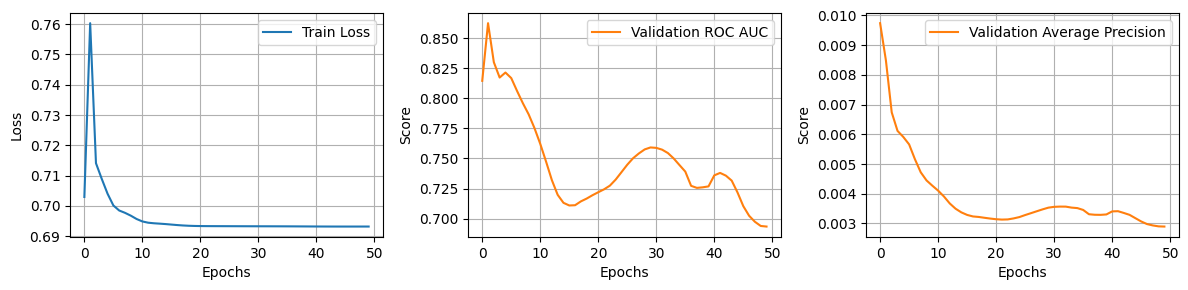

In [336]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(train_losses, label="Train Loss")
axs[1].plot(val_roc_aucs, label="Validation ROC AUC", c="C1")
axs[2].plot(val_average_precisions, label="Validation Average Precision", c="C1")
for i in range(3):
	axs[i].set_xlabel("Epochs")
	axs[i].set_ylabel("Loss" if i == 0 else "Score")
	axs[i].legend()
	axs[i].grid()
plt.tight_layout()
plt.show()

In [337]:
test_roc_auc, test_average_precision = test(model, test_data)
print(f"Test ROC AUC: {test_roc_auc}, Test Average Precision: {test_average_precision}")

Test ROC AUC: 0.726798107210099, Test Average Precision: 0.002776971589086127


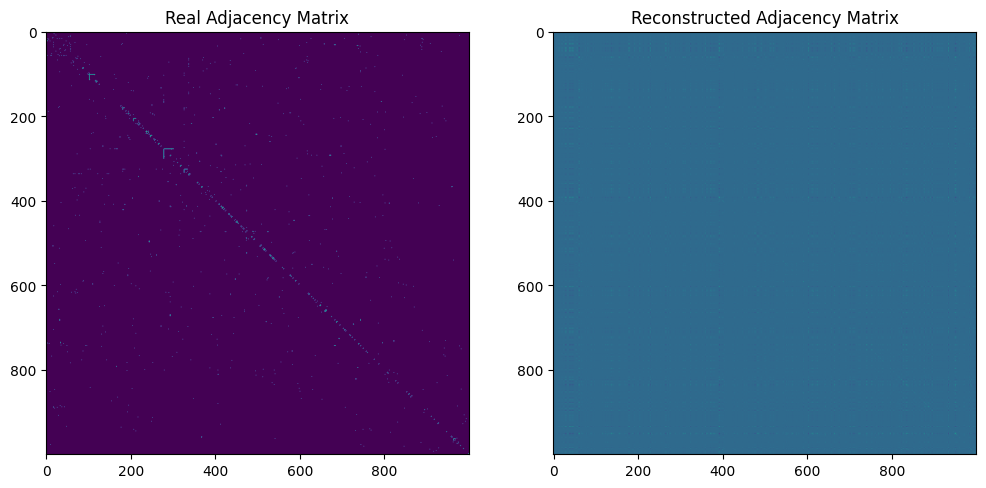

In [349]:
# showing the difference between real and reconstructed adjacency matrix
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(test_data.adj.detach().numpy())
axs[0].set_title("Real Adjacency Matrix")
axs[1].imshow(model(test_data.x, test_data.edge_index).detach().numpy())
axs[1].set_title("Reconstructed Adjacency Matrix")
plt.show()

In [356]:
model.encoder.conv1

GCNConv(1433, 64)